In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

In [3]:
# KNN Imputer for Item_Weight
imputer = KNNImputer(n_neighbors=5)
df1['Item_Weight'] = imputer.fit_transform(df1[['Item_Weight']])
df2['Item_Weight'] = imputer.transform(df2[['Item_Weight']])

# Fill missing Outlet_Size with a new category 'Unknown'
df1['Outlet_Size'].fillna('Unknown', inplace=True)
df2['Outlet_Size'].fillna('Unknown', inplace=True)

C:\Users\Amrutha\AppData\Local\Temp\ipykernel_33732\418184361.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Outlet_Size'].fillna('Unknown', inplace=True)
C:\Users\Amrutha\AppData\Local\Temp\ipykernel_33732\418184361.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [4]:
# Item_Type categorization
def item_identify(item_id):
    if item_id[:2] == 'NC':
        return 'Non Consumables'
    elif item_id[:2] == 'DR':
        return 'Drinks'
    else:
        return 'Foods'

In [5]:
df1['Item_Type_New'] = df1['Item_Identifier'].apply(item_identify)
df2['Item_Type_New'] = df2['Item_Identifier'].apply(item_identify)

In [6]:
# Standardize Item_Fat_Content
def item_fat_content(fat, typ):
    if (fat in ['Low Fat', 'LF', 'low fat']) and (typ in ['Foods', 'Drinks']):
        return 'Low Fat'
    elif (fat in ['Regular', 'reg']) and (typ in ['Foods', 'Drinks']):
        return 'Regular'
    else:
        return 'Non Edible'

In [7]:
df1['Item_Fat_Content'] = df1.apply(lambda x: item_fat_content(x['Item_Fat_Content'], x['Item_Type_New']), axis=1)
df2['Item_Fat_Content'] = df2.apply(lambda x: item_fat_content(x['Item_Fat_Content'], x['Item_Type_New']), axis=1)

In [8]:
# Fill zero values in Item_Visibility with median
df1['Item_Visibility'] = df1['Item_Visibility'].replace(0, df1['Item_Visibility'].median())
df2['Item_Visibility'] = df2['Item_Visibility'].replace(0, df2['Item_Visibility'].median())

In [9]:
# Calculate years of operation
df1['Years_of_Operation'] = 2013 - df1['Outlet_Establishment_Year']
df2['Years_of_Operation'] = 2013 - df2['Outlet_Establishment_Year']

In [10]:
# Log transform Item_Outlet_Sales to reduce skewness
df1['Item_Outlet_Sales'] = np.log1p(df1['Item_Outlet_Sales'])

In [11]:
# Drop identifier columns that are not used as features
df1.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Type'], inplace=True)
df2.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Type'], inplace=True)

In [12]:
# One-hot encoding for categorical features
df1 = pd.get_dummies(df1, columns=['Item_Fat_Content', 'Item_Type_New', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])
df2 = pd.get_dummies(df2, columns=['Item_Fat_Content', 'Item_Type_New', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])

In [13]:
# Align the test set columns to the training set
df2 = df2.reindex(columns = df1.columns, fill_value=0)

In [14]:
# Separate features and target
x = df1.drop(['Item_Outlet_Sales'], axis=1)
y = df1['Item_Outlet_Sales']
x_test = df2.drop(['Item_Outlet_Sales'], axis=1, errors='ignore')

In [15]:
# Feature scaling with RobustScaler
scaler = RobustScaler()
x = scaler.fit_transform(x)
x_test = scaler.transform(x_test)

In [16]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

In [17]:
# Model training and evaluation function
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    print(f"Mean Absolute Error: {mean_absolute_error(y_val, y_pred)}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2 Score: {r2}\n")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_val, y=y_pred, color="blue", edgecolor='w')
    plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
    plt.xlabel('Actual Item_Outlet_Sales')
    plt.ylabel('Predicted Item_Outlet_Sales')
    plt.title(f'Actual vs Predicted')
    plt.show()
    return model

In [18]:
#catboost

In [19]:
df1

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Years_of_Operation,Item_Fat_Content_Low Fat,Item_Fat_Content_Non Edible,Item_Fat_Content_Regular,Item_Type_New_Drinks,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_Unknown,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.300,0.016047,249.8092,1999,8.225808,14,True,False,False,False,...,True,False,False,True,False,False,False,True,False,False
1,5.920,0.019278,48.2692,2009,6.096776,4,False,False,True,True,...,True,False,False,False,False,True,False,False,True,False
2,17.500,0.016760,141.6180,1999,7.648868,14,True,False,False,False,...,True,False,False,True,False,False,False,True,False,False
3,19.200,0.053931,182.0950,1998,6.597664,15,False,False,True,False,...,False,False,True,False,False,True,True,False,False,False
4,8.930,0.053931,53.8614,1987,6.903451,26,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,1987,7.929984,26,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
8519,8.380,0.046982,108.1570,2002,6.310436,11,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
8520,10.600,0.035186,85.1224,2004,7.085159,9,False,True,False,False,...,False,True,False,False,True,False,False,True,False,False
8521,7.210,0.145221,103.1332,2009,7.521100,4,False,False,True,False,...,True,False,False,False,False,True,False,False,True,False


In [20]:
df1.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Years_of_Operation',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Non Edible',
       'Item_Fat_Content_Regular', 'Item_Type_New_Drinks',
       'Item_Type_New_Foods', 'Item_Type_New_Non Consumables',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Size_Unknown', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

0:	learn: 0.9525765	total: 161ms	remaining: 26.1s
1:	learn: 0.8960461	total: 168ms	remaining: 13.5s
2:	learn: 0.8449992	total: 174ms	remaining: 9.3s
3:	learn: 0.8008600	total: 181ms	remaining: 7.2s
4:	learn: 0.7618000	total: 188ms	remaining: 5.94s
5:	learn: 0.7286628	total: 194ms	remaining: 5.08s
6:	learn: 0.6992602	total: 200ms	remaining: 4.46s
7:	learn: 0.6726039	total: 206ms	remaining: 3.99s
8:	learn: 0.6508270	total: 212ms	remaining: 3.63s
9:	learn: 0.6322938	total: 218ms	remaining: 3.34s
10:	learn: 0.6158169	total: 224ms	remaining: 3.1s
11:	learn: 0.6013125	total: 230ms	remaining: 2.9s
12:	learn: 0.5886011	total: 236ms	remaining: 2.72s
13:	learn: 0.5776973	total: 242ms	remaining: 2.58s
14:	learn: 0.5693647	total: 248ms	remaining: 2.45s
15:	learn: 0.5616438	total: 254ms	remaining: 2.33s
16:	learn: 0.5550075	total: 260ms	remaining: 2.23s
17:	learn: 0.5492531	total: 265ms	remaining: 2.14s
18:	learn: 0.5442385	total: 272ms	remaining: 2.06s
19:	learn: 0.5399711	total: 278ms	remaining: 

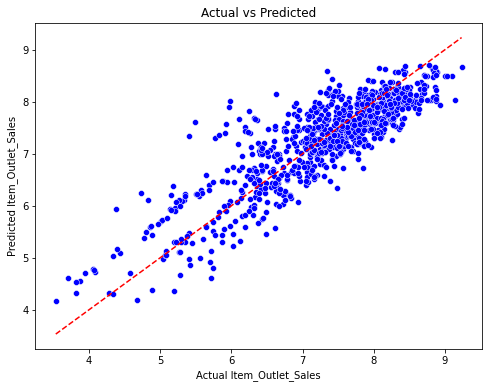

In [21]:
import pandas as pd
from catboost import CatBoostRegressor

# Initialize the CatBoost regressor
catboost_regressor = CatBoostRegressor(iterations=163, learning_rate=0.09, depth=6, loss_function='RMSE')
# Train the CatBoost regressor
catboost_regressor.fit(x, y)
# Predict sales on the test set
y_pred = catboost_regressor.predict(x_test)

evaluate_model(catboost_regressor, x_train, y_train, x_val, y_val)

In [22]:
#xgboost

Mean Absolute Error: 0.4048764942940218
Mean Squared Error: 0.26508675255426245
Root Mean Squared Error: 0.5148657616838223
R^2 Score: 0.7475621303089091



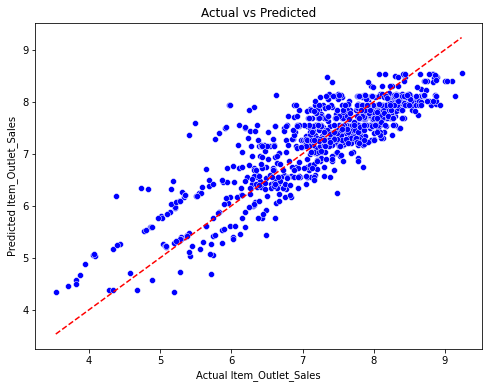

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=41, n_jobs=None, nthread=4,
             num_parallel_tree=None, ...)

In [23]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=x,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          learning_rate =0.09,
                          n_estimators=41,
                          max_depth=3,
                          min_child_weight=5,
                          gamma=0,
                          subsample=0.75,
                          colsample_bytree=0.95,
                          nthread=4,
                          scale_pos_weight=1,
                          reg_alpha=0.021,
                          seed=42,
                          )
xg_reg.fit(x_train,y_train)

pred2 = xg_reg.predict(x_val)
evaluate_model(xg_reg , x_train, y_train, x_val, y_val)

In [24]:
#adaboost

Mean Absolute Error: 0.5071548555348009
Mean Squared Error: 0.36497274954860015
Root Mean Squared Error: 0.6041297456247293
R^2 Score: 0.6524422948201103



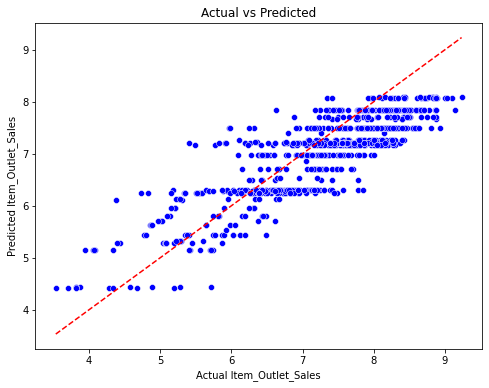

In [25]:

# AdaBoostRegressor
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

np.random.seed(42)

# Assuming x_train, x_test, y_train, y_test are your train and test data

# Initialize the AdaBoost regressor with default decision tree base estimator
adaboost_regressor = AdaBoostRegressor(n_estimators=100, learning_rate=2.0)

# Train the AdaBoost regressor
adaboost_regressor.fit(x_train, y_train)

# Predict sales on the test set
y_pred = adaboost_regressor.predict(x_val)

adaboost_model = evaluate_model(adaboost_regressor, x_train, y_train, x_val, y_val)

In [26]:
import joblib
joblib.dump(adaboost_regressor, 'adaboost_regressor_model.pkl')


['adaboost_regressor_model.pkl']